# Real-Time Financial Fraud Detection using Anomaly Detection

This project implements an industry-grade real-time financial fraud detection system 
using anomaly detection and deep learning techniques.

The system is trained on historical transaction data (fraudTrain.csv) 
and evaluated on future unseen transactions (fraudTest.csv) to simulate 
real-time fraud detection.

Models used:
- Isolation Forest for global anomaly detection
- Autoencoder for behavioral deviation detection
- LSTM for sequential transaction analysis

The outputs of these models are combined into a risk score that drives 
business decisions such as ALLOW, VERIFY, or BLOCK.


In [13]:
# Numerical computation
import numpy as np
import pandas as pd

# Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Anomaly detection
from sklearn.ensemble import IsolationForest

# Evaluation metrics
from sklearn.metrics import roc_auc_score, precision_recall_curve

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.optimizers import Adam

# Visualization
import matplotlib.pyplot as plt


In [14]:
# Load training (historical) data
train_df = pd.read_csv("/kaggle/input/fraud-detection/fraudTrain.csv")

# Load testing (future/unseen) data
test_df = pd.read_csv("/kaggle/input/fraud-detection/fraudTest.csv")

# Check first few rows
train_df.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [15]:
# Dataset shape
print("Training data shape:", train_df.shape)
print("Testing data shape:", test_df.shape)

print("\nTraining fraud distribution:")
print(train_df['is_fraud'].value_counts())

print("\nTesting fraud distribution:")
print(test_df['is_fraud'].value_counts())


Training data shape: (1296675, 23)
Testing data shape: (555719, 23)

Training fraud distribution:
is_fraud
0    1289169
1       7506
Name: count, dtype: int64

Testing fraud distribution:
is_fraud
0    553574
1      2145
Name: count, dtype: int64


In [16]:
# Convert transaction timestamp to datetime
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'])
test_df['trans_date_trans_time'] = pd.to_datetime(test_df['trans_date_trans_time'])

# Extract time-based features
for df in [train_df, test_df]:
    df['transaction_hour'] = df['trans_date_trans_time'].dt.hour
    df['transaction_day'] = df['trans_date_trans_time'].dt.day
    df['transaction_month'] = df['trans_date_trans_time'].dt.month
    df['is_night_transaction'] = df['transaction_hour'].apply(
        lambda x: 1 if x >= 22 or x <= 5 else 0
    )

train_df[['trans_date_trans_time', 'transaction_hour', 'is_night_transaction']].head()


,trans_date_trans_time,transaction_hour,is_night_transaction
0,2019-01-01 00:00:18,0,1
1,2019-01-01 00:00:44,0,1
2,2019-01-01 00:00:51,0,1
3,2019-01-01 00:01:16,0,1
4,2019-01-01 00:03:06,0,1


In [17]:
# Log transform transaction amount to reduce skewness
train_df['log_amt'] = np.log1p(train_df['amt'])
test_df['log_amt'] = np.log1p(test_df['amt'])

# Select numerical features for scaling
num_features = [
    'log_amt',
    'transaction_hour',
    'transaction_day',
    'transaction_month',
    'is_night_transaction'
]

# Initialize scaler
scaler = StandardScaler()

# Fit scaler ONLY on training data
train_df[num_features] = scaler.fit_transform(train_df[num_features])

# Apply same scaler to test data
test_df[num_features] = scaler.transform(test_df[num_features])

train_df[num_features].head()


,log_amt,transaction_hour,transaction_day,transaction_month,is_night_transaction
0,-1.354630,-1.878145,-1.652258,-1.504564,1.527768
1,0.892466,-1.878145,-1.652258,-1.504564,1.527768
2,1.446503,-1.878145,-1.652258,-1.504564,1.527768
3,0.228913,-1.878145,-1.652258,-1.504564,1.527768
4,0.175889,-1.878145,-1.652258,-1.504564,1.527768


In [18]:
# Select categorical features
cat_features = [
    'category',
    'gender',
    'state'
]

# One-hot encode categorical features
train_df = pd.get_dummies(train_df, columns=cat_features, drop_first=True)
test_df = pd.get_dummies(test_df, columns=cat_features, drop_first=True)

# Align train and test to have same columns
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

train_df.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,amt,first,last,street,city,zip,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",4.97,Jennifer,Banks,561 Perry Cove,Moravian Falls,28654,...,False,False,False,False,False,False,False,False,False,False
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",107.23,Stephanie,Gill,43039 Riley Greens Suite 393,Orient,99160,...,False,False,False,False,False,False,True,False,False,False
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,220.11,Edward,Sanchez,594 White Dale Suite 530,Malad City,83252,...,False,False,False,False,False,False,False,False,False,False
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",45.00,Jeremy,White,9443 Cynthia Court Apt. 038,Boulder,59632,...,False,False,False,False,False,False,False,False,False,False
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,41.96,Tyler,Garcia,408 Bradley Rest,Doe Hill,24433,...,False,False,False,False,True,False,False,False,False,False


In [19]:
# Columns that should NOT be used for modeling
drop_cols = [
    'is_fraud',
    'trans_date_trans_time',
    'cc_num',
    'trans_num',
    'first',
    'last',
    'street',
    'city',
    'zip',
    'dob'
]

# Prepare training data
X_train = train_df.drop(columns=drop_cols)
y_train = train_df['is_fraud']

# Prepare testing data
X_test = test_df.drop(columns=drop_cols)
y_test = test_df['is_fraud']

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (1296675, 79)
X_test shape: (555719, 79)


In [21]:
# Keep only numeric columns for modeling
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

print("Final numeric X_train shape:", X_train.shape)
print("Final numeric X_test shape:", X_test.shape)


Final numeric X_train shape: (1296675, 13)
Final numeric X_test shape: (555719, 14)


In [23]:
# Save training feature names (schema)
train_features = X_train.columns

# Reindex test data to match training schema exactly
X_test = X_test.reindex(columns=train_features, fill_value=0)

print("Train feature count:", X_train.shape[1])
print("Test feature count:", X_test.shape[1])


Train feature count: 13
Test feature count: 13


In [24]:
# Train Isolation Forest on NORMAL transactions only
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.005,
    random_state=42,
    n_jobs=-1
)

# Fit only on non-fraud data
iso_forest.fit(X_train[y_train == 0])

# Generate anomaly scores for train and test
train_iso_scores = -iso_forest.decision_function(X_train)
test_iso_scores = -iso_forest.decision_function(X_test)

train_iso_scores[:5]


array([-0.06868187, -0.00706571, -0.02115304, -0.03861353, -0.08893821])

In [25]:
# Autoencoder input dimension
input_dim = X_train.shape[1]

# Define Autoencoder architecture
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)

# Decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

# Build model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile model
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,933 (23.18 KB)

 Trainable params: 5,933 (23.18 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Select only non-fraud transactions for training
X_train_normal = X_train[y_train == 0]

# Train autoencoder
history = autoencoder.fit(
    X_train_normal,
    X_train_normal,
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)


Epoch 1/10


I0000 00:00:1770574201.682901     140 service.cc:152] XLA service 0x7e96b80050e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770574201.682948     140 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770574201.682952     140 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1770574202.021474     140 cuda_dnn.cc:529] Loaded cuDNN version 91002


  83/4533 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 121539139161030656.0000

I0000 00:00:1770574203.216381     140 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4533/4533 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 7365719125655552.0000 - val_loss: 57701818368.0000
Epoch 2/10
4533/4533 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 82808070144.0000 - val_loss: 116897685504.0000
Epoch 3/10
4533/4533 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 202654957568.0000 - val_loss: 42206429184.0000
Epoch 4/10
4533/4533 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 202681761792.0000 - val_loss: 72855281664.0000
Epoch 5/10
4533/4533 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 216481431552.0000 - val_loss: 74902355968.0000
Epoch 6/10
4533/4533 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 176682336256.0000 - val_loss: 62386044928.0000
Epoch 7/10
4533/4533 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 164679106560.0000 - val_loss: 175056224256.0000
Epoch 8/10
4533/4533 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 169915973632.0000 - val_loss: 113090977792.0000
Epoch 9/10
4533/4533 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 151424286720.0000 - val_loss: 979780567040.0000
Epoch 10/10
4533/4533 

In [27]:
# Reconstruct transactions using trained autoencoder
train_reconstructions = autoencoder.predict(X_train)
test_reconstructions = autoencoder.predict(X_test)

# Calculate reconstruction error (MSE per transaction)
train_ae_errors = np.mean(
    np.square(X_train - train_reconstructions),
    axis=1
)

test_ae_errors = np.mean(
    np.square(X_test - test_reconstructions),
    axis=1
)

train_ae_errors[:5]


40522/40522 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step
17367/17367 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step


0    1.090054e+11
1    1.090370e+11
2    1.089948e+11
3    1.090163e+11
4    1.090313e+11
dtype: float64

In [29]:
# Sequence length (number of past transactions to look at)
SEQUENCE_LENGTH = 10

def create_sequences(X, y, seq_len):
    X_sequences = []
    y_sequences = []
    
    for i in range(len(X) - seq_len):
        X_sequences.append(X.iloc[i:i + seq_len].values)
        y_sequences.append(y.iloc[i + seq_len])
    
    return np.array(X_sequences), np.array(y_sequences)

# Create sequences for training data
X_train_seq, y_train_seq = create_sequences(X_train, y_train, SEQUENCE_LENGTH)

# Create sequences for testing data
X_test_seq, y_test_seq = create_sequences(X_test, y_test, SEQUENCE_LENGTH)

print("Train sequence shape:", X_train_seq.shape)
print("Test sequence shape:", X_test_seq.shape)


Train sequence shape: (1296665, 10, 13)
Test sequence shape: (555709, 10, 13)


In [30]:
# Define LSTM model
lstm_model = Sequential([
    LSTM(
        units=64,
        input_shape=(SEQUENCE_LENGTH, X_train.shape[1]),
        return_sequences=False
    ),
    Dense(1, activation='sigmoid')
])

# Compile model
lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy'
)

lstm_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train LSTM model
history_lstm = lstm_model.fit(
    X_train_seq,
    y_train_seq,
    epochs=5,
    batch_size=256,
    validation_split=0.1,
    verbose=1
)


Epoch 1/5
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.0916 - val_loss: 0.0389
Epoch 2/5
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0353 - val_loss: 0.0390
Epoch 3/5
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0354 - val_loss: 0.0388
Epoch 4/5
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0353 - val_loss: 0.0388
Epoch 5/5
4559/4559 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0355 - val_loss: 0.0389


In [32]:
# Predict fraud probabilities using LSTM
train_lstm_probs = lstm_model.predict(X_train_seq).flatten()
test_lstm_probs = lstm_model.predict(X_test_seq).flatten()

# Pad the first SEQUENCE_LENGTH transactions with zeros
train_lstm_probs = np.concatenate([
    np.zeros(SEQUENCE_LENGTH),
    train_lstm_probs
])

test_lstm_probs = np.concatenate([
    np.zeros(SEQUENCE_LENGTH),
    test_lstm_probs
])

print(train_lstm_probs[:15])


40521/40521 ━━━━━━━━━━━━━━━━━━━━ 54s 1ms/step
17366/17366 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00510194 0.00510194
 0.00510194 0.00510194 0.00510194]


In [33]:
# Min-Max normalization function
def normalize(scores):
    return (scores - scores.min()) / (scores.max() - scores.min())

# Normalize Isolation Forest scores
train_iso_norm = normalize(train_iso_scores)
test_iso_norm = normalize(test_iso_scores)

# Normalize Autoencoder reconstruction errors
train_ae_norm = normalize(train_ae_errors)
test_ae_norm = normalize(test_ae_errors)

# Normalize LSTM probabilities
train_lstm_norm = normalize(train_lstm_probs)
test_lstm_norm = normalize(test_lstm_probs)

train_iso_norm[:5], train_ae_norm[:5], train_lstm_norm[:5]


(array([0.45358263, 0.64670731, 0.60255312, 0.54782639, 0.3900928 ]),
 0    0.056178
 1    0.056413
 2    0.056099
 3    0.056259
 4    0.056371
 dtype: float64,
 array([0., 0., 0., 0., 0.]))

In [34]:
# Define ensemble weights (business-calibrated)
W_ISO = 0.4
W_AE = 0.35
W_LSTM = 0.25

# Compute risk score
train_risk_score = (
    W_ISO * train_iso_norm +
    W_AE * train_ae_norm +
    W_LSTM * train_lstm_norm
)

test_risk_score = (
    W_ISO * test_iso_norm +
    W_AE * test_ae_norm +
    W_LSTM * test_lstm_norm
)

train_risk_score[:10]


0    0.201095
1    0.278427
2    0.260656
3    0.238821
4    0.175767
5    0.181890
6    0.198407
7    0.172066
8    0.195393
9    0.212065
dtype: float64

In [35]:
# Decision logic based on risk score
def fraud_decision(score):
    if score < 0.3:
        return "ALLOW"
    elif score < 0.6:
        return "VERIFY"
    else:
        return "BLOCK"

# Apply decision logic
train_decisions = train_risk_score.apply(fraud_decision) if hasattr(train_risk_score, "apply") \
                  else np.array([fraud_decision(s) for s in train_risk_score])

test_decisions = test_risk_score.apply(fraud_decision) if hasattr(test_risk_score, "apply") \
                 else np.array([fraud_decision(s) for s in test_risk_score])

train_decisions[:10]


0    ALLOW
1    ALLOW
2    ALLOW
3    ALLOW
4    ALLOW
5    ALLOW
6    ALLOW
7    ALLOW
8    ALLOW
9    ALLOW
dtype: object

ROC-AUC Score: 0.8512426278694204
PR-AUC Score: 0.03034393986035913


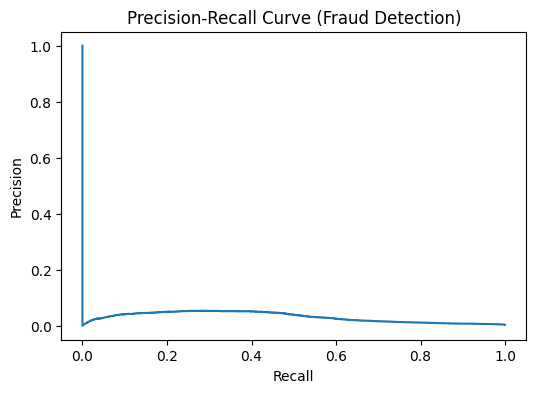

In [36]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# ROC-AUC score (using risk score)
roc_auc = roc_auc_score(y_test, test_risk_score)
print("ROC-AUC Score:", roc_auc)

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, test_risk_score)
pr_auc = auc(recall, precision)

print("PR-AUC Score:", pr_auc)

# Plot Precision-Recall curve
plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Fraud Detection)")
plt.show()


In [37]:
# Precision @ Top 1%

import numpy as np

# number of samples in top 1%
k = int(0.01 * len(test_risk_score))

# indices of top 1% highest risk scores
top_1pct_indices = np.argsort(test_risk_score)[-k:]

# precision = fraction of frauds in top 1%
precision_at_1pct = y_test.iloc[top_1pct_indices].mean()

print("Precision @ Top 1%:", precision_at_1pct)


Precision @ Top 1%: 0.042289004858736726
